In [1]:
# %%writefile box.py
from copy import deepcopy

class Box:
    def __init__(self, x, y):
        self.coordinates = [(x, y), (x + 1, y), (x, y + 1), (x + 1, y + 1)]
        
        self.XY = (x, y)

        # lines
        self.TopLine = (self.coordinates[0], self.coordinates[1])
        self.LeftLine = (self.coordinates[0], self.coordinates[2])
        self.RightLine = (self.coordinates[1], self.coordinates[3])
        self.BottomLine = (self.coordinates[2], self.coordinates[3])
        # lines 
        self.lines = [self.TopLine, self.LeftLine, self.RightLine, self.BottomLine]

        # lines connection indicator 
        self._top = False
        self._left = False
        self._right = False
        self._bottom = False

        self.owner = None
        self.completed = False

        self.value = 1

    def connect(self, coordinates):
        line = coordinates
        success = False

        if line not in self.lines:
            return False
        
        if line == self.TopLine and self._top is False:
            self._top = True
            success = True
        elif line == self.LeftLine and self._left is False:
            self._left = True
            success = True
        elif line == self.RightLine and self._right is False:
            self._right = True
            success = True
        elif line == self.BottomLine and self._bottom is False:
            self._bottom = True
            success = True

        if self._top == True and self._bottom == True and self._left == True and self._right == True:
            self.completed = True
        
        return success

    def copy(self):
        return deepcopy(self)
    
    def _repr_pretty_(self, p, cycle):
        if cycle:
            pass

        if self._top:
            p.text("*---*")
        else:
            p.text("*   *")
        p.break_()
        if self._left:
            p.text("|")
        else:
            p.text(" ")
        
        if self.completed:
            p.text(f" {self.owner} ")
        else:
            p.text("   ") 

        if self._right:
            p.text("|")

        p.break_()

        if self._bottom:
            p.text("*---*")
        else:
            p.text("*   *")



In [22]:
# %%writefile board.py
from collections import deque
from copy import deepcopy

class Board:
    display_single_box = False

    def __init__(self, m, n):
        self.player_score = 0
        self.ai_score = 0
        self.m = m
        self.n = n
        self._boxes = self._generate_boxes(m, n)
        self._open_vectors = self._generate_vectors(m, n)
        self._connected_vectors = set()

    def _generate_boxes(self, rows, cols):
        """
        This function generates the boxes of the board
        """
        boxes = [[Box(x, y) for x in range(cols)] for y in range(rows)]

        return boxes
    
    def _generate_vectors(self, m, n):
        '''
        The vectors represent the available moves, or lines, which can
        be played on a game board of m rows and n columns. These are stored as tuples
        containing each coordinate and are stored in a queue. The vector queue, along
        with the list of boxes that correspond to the coordinates, are used to represent
        game state.
        Vector format: ((x1, y1), (x2, y2)).

        The vectors always point away from the origin (0, 0), so moving like (1, 0) => (0, 0)
        is not a valid move while (0, 0) => (1, 0) is a valid move
        '''
        vectors = set()
        for i in range(0, m + 1):
            for j in range(0, n):
                # Adding horizontal line vectors
                vectors.add(((j, i), (j + 1, i)))
                # Adding vertical line vectors if not in the last row
                if i < m:
                    vectors.add(((j, i), (j, i + 1)))
            # Adding the vertical line for the last column in the current row
            if i < m:
                vectors.add(((n, i), (n, i + 1)))
        return vectors

    def move(self, coordinates, player_move: bool = False):
        player = "P" if player_move == True else "A"
        
        if coordinates in self._open_vectors:
            self._open_vectors.remove(coordinates)
            self._connected_vectors.add(coordinates)
            self._checkboxes(coordinates, player)
            # print("board: moved")
        
    def has_moves(self):
        # return len(self._open_vectors) != 0
        return bool(self._open_vectors)

    def get_available_moves(self):
        return self._open_vectors
        
    def _checkboxes(self, coordinates, player: str):
        for i in range(self.m):
            for j in range(self.n):
                box = self._boxes[i][j]
                if coordinates in box.lines:
                    box.connect(coordinates)
                if box.completed == True and box.owner == None:
                    box.owner = player
                    self.prevComplete = True
                    if player == "P":
                        self.player_score += 1
                    else:
                        self.ai_score += 1
    
    def copy(self):
        return deepcopy(self)

    def display_board(self):
        # Display player scores
        print(f"Player 1: {self.player_score}")
        print(f"Player AI: {self.ai_score}\n")

        # Display the board
        for i in range(self.m):
            # Top line of each row
            top_line = "   "  # Start with some spacing for alignment
            middle_line = "   "  # Line below to display vertical lines and boxes
            
            for j in range(self.n):
                # Dot
                top_line += "*"

                # Horizontal line
                if ((j, i), (j + 1, i)) in self._connected_vectors:
                    top_line += "---"
                else:
                    top_line += "   "
                
                # Vertical line and box
                if ((j, i), (j, i + 1)) in self._connected_vectors:
                    middle_line += "|"
                else:
                    middle_line += " "
                
                # Box ownership
                if self._boxes[j][i].completed:
                    middle_line += f" {self._boxes[j][i].owner} "
                else:
                    middle_line += "   "
            
            # Last dot on the right end of the row
            top_line += "*"
            if ((self.n, i), (self.n, i + 1)) in self._connected_vectors:
                middle_line += "|"
            else:
                middle_line += " "
            
            # Print the top line and the middle line
            print(top_line)
            print(middle_line)

        # Bottom line of the last row
        bottom_line = "   "
        for j in range(self.n):
            bottom_line += "*"
            if ((j, self.m), (j + 1, self.m)) in self._connected_vectors:
                bottom_line += "---"
            else:
                bottom_line += "   "
        bottom_line += "*"
        
        # Print the bottom line
        print(bottom_line)
        print("")  # New line for spacing
    
    def _repr_pretty_(self, p, cycle):
        if (cycle):
            pass

        # Display player scores
        # p.text(f"    AI Score : {self.aiScore}\n")
        # p.text(f"Player Score : {self.playerScore}\n")

        if Board.display_single_box:
            self.__display_single_box(p)
        else:
            self.__display_multi_box(p)
        
    def __display_single_box(self, p):
        last_line = ""
        for i in range(self.m - 1):
            top_line = "\t*"
            middle_line = "\t"
            last_line = "\t*"

            for j in range(self.n):
                box = self._boxes[i][j]
                top_line += "---*" if box._top else "   *"
                middle_line += "|" if box._left else " "
                if box.completed:
                    middle_line += f" {box.owner} "
                else:
                    middle_line += "   "
                last_line += "---*" if box._bottom else "   *"

            
            if box and box._right:
                middle_line += "|"
            
            p.text(top_line)
            p.break_()
            p.text(middle_line)
            p.break_()

        p.text(last_line)
        p.break_()
    
    def __display_multi_box(self, p):
        for i in range(self.m):
            top_line = "\t"
            middle_line = "\t"
            bottom_line = "\t"

            for j in range(self.n):
                box = self._boxes[i][j]
                top_line += "*---*" if box._top else "*   *"
                middle_line += "|" if box._left else " "
                if box.completed:
                    middle_line += f" {box.owner} "
                else:
                    middle_line += "   "
                middle_line += "|" if box._right else " "
                bottom_line += "*---*" if box._bottom else "*   *"
            
            p.text(top_line)
            p.break_()
            p.text(middle_line)
            p.break_()
            p.text(bottom_line)
            p.break_()
            


In [3]:
Board.display_single_box = False

In [4]:
Board(3, 3)

	*   **   **   *
	               
	*   **   **   *
	*   **   **   *
	               
	*   **   **   *
	*   **   **   *
	               
	*   **   **   *


In [5]:
# from board import Board

board = Board(2, 2)
board

	*   **   *
	          
	*   **   *
	*   **   *
	          
	*   **   *


In [25]:
board.move(((0, 1), (1, 1)))
board

	*   *   *
	    |   |
	*---*---*


In [6]:
board._boxes[0][0]

*   *
|   
*   *

In [53]:
from copy import deepcopy
import random

class GameManager:
    def __init__(self, m, n, level, mode = "minimax"):
        self._level = level
        self._board = Board(m, n)

        if mode == "alphabeta":
            self._mode = self.alpha_beta
        else:
            self._mode = self.mini_max
    
    def _repr_pretty_(self, p, cycle):
        if (cycle):
            pass

        # Display player scores
        p.text(f"    AI Score : {self._board.ai_score}\n")
        p.text(f"Player Score : {self._board.player_score}\n")
        self._board._repr_pretty_(p, cycle)

    def get_victor(self):
        print("The game ended")
        print(f"Score: Player={self._board.player_score}, AI={self._board.ai_score}")
        
        if self._board.player_score > self._board.ai_score:
            victor = "player"
        elif self._board.player_score < self._board.ai_score:
            victor = "ai"
        else:
            victor = "draw"

        return victor

    def ai_start(self):
        pass

    def get_move(self, origin, dest):
        # if origin[0] > dest[0] or origin[1] > dest[1]:
        #     origin, dest = dest, origin
        coordinates = (origin, dest)
        # print("entered move=", coordinates)
        self._board.move(coordinates, player_move = True)

        if not self._board.has_moves():
            return self.get_victor()

        board = deepcopy(self._board)
        next = self._mode(board, self._level, True)
        # print("next move", next[1])
        
        self._board.move(next[1])
        return next[1]

    def mini_max(self, state: Board, ply: int, max_min: bool):
        if ply == 0 or len(state._open_vectors) == 0:
            h = self.evaluate(state)
            return (h, None)
        
        best_move = None
        
        # ai turn
        if max_min is True:
            max_val = float('-inf')
            for move in state.get_available_moves():
                new_state = deepcopy(state)
                new_state.move(move, player_move = False)
                eval, _ = self.mini_max(new_state, ply - 1, False)
                if eval > max_val:
                    max_val = eval
                    best_move = move
            
            return (max_val, best_move)
        
        # player turn
        else:
            min_val = float('inf')
            for move in state.get_available_moves():
                new_state = deepcopy(state)
                new_state.move(move, player_move = True)
                eval, _ = self.mini_max(new_state, ply - 1, True)
                if eval < min_val:
                    min_val = eval
                    best_move = move
            
            return (min_val, best_move)
    
    def alpha_beta(self, state: Board, ply: int, is_max: bool, alpha: float, beta: float):
        if ply == 0 or not state.has_moves():
            h = self.evaluate(state)
            return (h, None)

        best_move = None

        if is_max:
            max_val = float("-inf")
            for move in state.get_available_moves():
                new_state = deepcopy(state)
                new_state.move(move, player_move = False)
                eval, _ = self.alpha_beta(new_state, ply - 1, False, alpha, beta)
                if eval > max_val:
                    max_val = eval
                    best_move = move
                
                alpha = max(alpha, max_val)

                if beta <= alpha:
                    break

            return (max_val, best_move)
        else:
            min_val = float('inf')
            for move in state.get_available_moves():
                new_state = deepcopy(state)
                new_state.move(move, player_move = True)
                eval, _ = self.alpha_beta(new_state, ply - 1, True, alpha, beta)
                if eval < min_val:
                    min_val = eval
                    best_move = move
                
                beta = min(beta, min_val)

                if beta <= alpha:
                    break

            return (min_val, best_move)                

    def evaluate(self, state: Board):
        return random.randint(0, 100)
    


In [59]:
game_min = GameManager(5, 5, 3)
print(game_min._mode)
game_min

<bound method GameManager.mini_max of <__main__.GameManager object at 0x748eb5642f60>>


    AI Score : 0
Player Score : 0
	*   **   **   **   **   *
	                         
	*   **   **   **   **   *
	*   **   **   **   **   *
	                         
	*   **   **   **   **   *
	*   **   **   **   **   *
	                         
	*   **   **   **   **   *
	*   **   **   **   **   *
	                         
	*   **   **   **   **   *
	*   **   **   **   **   *
	                         
	*   **   **   **   **   *


In [57]:
game_alpha = GameManager(5, 5, 2, mode="alphabeta")
print(game_alpha._mode)
game_alpha

<bound method GameManager.alpha_beta of <__main__.GameManager object at 0x748eb570dee0>>


    AI Score : 0
Player Score : 0
	*   **   **   **   **   *
	                         
	*   **   **   **   **   *
	*   **   **   **   **   *
	                         
	*   **   **   **   **   *
	*   **   **   **   **   *
	                         
	*   **   **   **   **   *
	*   **   **   **   **   *
	                         
	*   **   **   **   **   *
	*   **   **   **   **   *
	                         
	*   **   **   **   **   *


In [60]:
move = game_min.get_move((1, 0), (1, 1))
print(move)
game_min

((4, 4), (5, 4))


    AI Score : 0
Player Score : 0
	*   **   **   **   **   *
	    ||                   
	*   **   **   **   **   *
	*   **   **   **   **   *
	                         
	*   **   **   **   **   *
	*   **   **   **   **   *
	                         
	*   **   **   **   **   *
	*   **   **   **   **   *
	                         
	*   **   **   **   **---*
	*   **   **   **   **---*
	                         
	*   **   **   **   **   *


In [48]:
move = game_min.get_move((1, 0), (1, 1))
print(move)
game_min

KeyboardInterrupt: 

In [47]:
len(game_min._board._open_vectors)

59

Numero de estados iniciales a partir de dimensiones $m$ y $n$  
$
N = m \times \left(n + 1\right) + \left(m + 1\right) \times n
$

Numero de posibles estados para profundidad $d$: $ S_d = \binom{ejes libres}{d} = \binom{n}{k}= \frac{n!}{k!(n-k)!} $


In [116]:
import math
import matplotlib.pyplot as plt
import numpy as np

def total_states_depth(N, d):
    s = 0
    for k in range(0, d + 1):
        s += math.comb(N, k)
    return s

In [126]:
m = 1
n = 1
d = 1

N = m * (n + 1) + (m + 1) * n
print("Total states:", N)
S = total_states_depth(N, d)
# S = 0
# for k in range(0, d + 1):
#     S += math.comb(N, k)
print("Total States for depth", f"{S:,}")

Total states: 4
Total States for depth 5


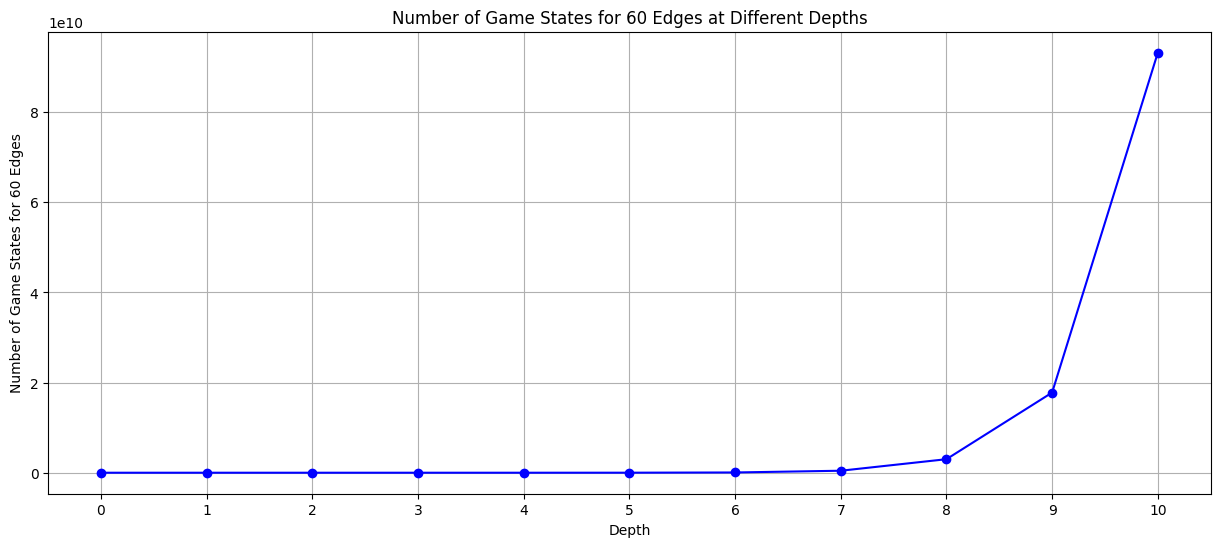

In [95]:
elements = N
depths = range(d + 1)
states_at_depth = [total_states_depth(N, d) for d in depths]

plt.figure(figsize=(15, 6))
plt.plot(depths, states_at_depth, marker='o', linestyle='-', color='b')
plt.xlabel('Depth')
plt.ylabel(f'Number of Game States for {N} Edges')
plt.title(f'Number of Game States for {N} Edges at Different Depths')
plt.grid(True)
plt.xticks(depths)
plt.show()

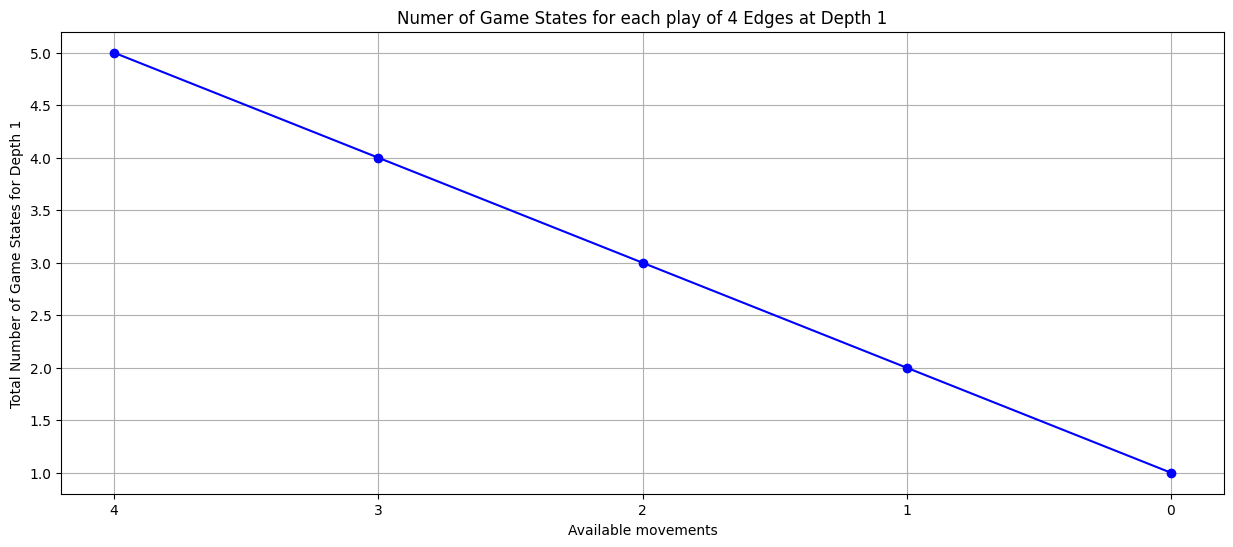

In [127]:
elements = range(N + 1)
states = [total_states_depth(n, d) for n in elements]

plt.figure(figsize=(15, 6))
plt.plot(elements, states, marker='o', linestyle='-', color='b')
plt.gca().invert_xaxis()
plt.xlabel('Available movements')
plt.ylabel(f'Total Number of Game States for Depth {d}')
plt.title(f'Numer of Game States for each play of {N} Edges at Depth {d}')
plt.grid(True)
plt.xticks(elements)
plt.show()